In [2]:
## 1. 배럴

## 배럴이란 타율 .5 이상, 장타율 1.5 이상을 생산하는 타구를 배럴이라고 한다. 
## 활용은 타석 당 배럴타구로 해서 배럴 지표를 유의한다.

## 프로야구에서 배럴을 어떻게 정의할 것인가.
## 주의 : 타자 기본 정보와 타자 트래킹 정보를 활용.

## 2. OPS 예측 모델링

## OPS = 장타율 + 출루율 
## 9월 15 ~ 10월 8일 경기없는 인원 제거
## 팀경기수 * 3.1 안되는 인원 제거
## OPS > 장타율 > 출루율 기준 작성
## 10명 : 76232,68050,75847,67341,79192,78224,78513,76290,79215,67872 예측.

In [3]:
## 타율 = 안타 / 타수 
## 타수 : 희생번트, 희생플라이, 볼넷, 몸에맞는볼, 타격방해 및 주루방해는 타석으로만 되고, 타수 x. 
## 상대의 실책일 경우에 아무일도 안일어났다 그러면 타석도 인정 안된다. 
## 타석 수는 정규경기*3.1 을 넘겨야 한다. 

## KBO리그는 MLB리그 보다 스트라이크 존이 작다. 참고.https://www.youtube.com/watch?v=3CUS5uGH9JU
## 국내 프로야구의 배럴의 의미는 재정의 되어야 한다. 
## 안타치기 어려운 국내 프로야구에서는 배럴의 의미를 타율과 출루율로 되어야한다.
## 타구 또한 평균 구종 속도가 낮기 때문에 속도도 재정의 되어야 한다. https://www.hani.co.kr/arti/sports/baseball/967678.html

## 데이터 설명.
## 스포츠테크 파일 : 타구 속도, 타구 각, 구종 속도 등의 데이터. 이걸로 barrel 정의
## 경기일정
## 선수 파일 : 연봉 
## 타자 파일 : 연도별 잘 정리된 스탯 데이터. 이걸로 지표를 만들어 barrel 정의 
## 팀 파일 : 팀 정보.

## 

In [4]:
## 2018,2019,2020,2021이 있고 2021을 예측하는 문제다.
## 2020으로만 예측하는게 가능할까? 2018의 agg와 2019,2020이 관련이 있다면 2021도 관련이 있지만, 아니라면 2020으로만 한다. 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
base='2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_데이터_210803/'
train_folder='01_제공데이터/'
test_folder='02_평가데이터/'

data2018=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2018.csv',encoding='cp949')
data2019=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2019.csv',encoding='cp949')
data2020=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2020.csv',encoding='cp949')

In [7]:
# data2020.head()

def datainfo(df):
    return pd.DataFrame([(col,df[col].nunique(),df[col].dtype,df[col].isna().sum(),df[col].unique()[:5]) for col in df.columns],
                       columns=['name','nunique','dtype','missing','value :5'])

datainfo(data2018)
# datainfo(data2019)
# datainfo(data2020)

,name,nunique,dtype,missing,value :5
0,GYEAR,1,int64,0,[2018]
1,PCODE,275,int64,0,"[60100, 60184, 60288, 60343, 60456]"
2,GAMENUM,118,int64,0,"[70, 6, 1, 83, 4]"
3,PA,185,int64,0,"[169, 10, 1, 174, 8]"
4,AB,186,int64,0,"[152, 10, 1, 162, 6]"
5,BA,136,float64,0,"[0.243, 0.2, 0.0, 0.216, 0.5]"
6,HIT,121,int64,0,"[37, 2, 0, 35, 3]"
7,HR,35,int64,0,"[3, 0, 8, 7, 12]"
8,TOTB,141,int64,0,"[63, 3, 0, 86, 144]"
9,SLG,187,float64,0,"[0.414, 0.3, 0.0, 0.389, 0.5]"


In [8]:
# 약어 alias
m={'GYEAR':'연도','PCODE':'선수코드','GAMENUM':'경기','PA':'타석','AB':'타수','BA':'타율','HIT':'안타','HR':'홈런','TOTB':'루타',
   'SLG':'장타율','SF':'희생플라이','BB':'볼넷','KK':'삼진','IB':'고의4구','HP':'사구','GD':'병살타','NAME':'선수명','T_ID':'팀코드',
   'POSITION':'포지션','AGE_VA':'나이','MONEY':'연봉','G_ID':'경기코드','PIT_ID':'타구코드','INN':'이닝','HIT_VEL':'타구속도(km/h)',
   'HIT_ANG_VER':'발사각도','HIT_RESULT':'타격결과','PIT_VEL':'상대투수 투구구속(km/h)','STADIUM':'해당구장'}

data2018=data2018.rename(columns=m)
data2019=data2019.rename(columns=m)
data2020=data2020.rename(columns=m)

data2020.head()

,연도,선수코드,경기,타석,타수,타율,안타,홈런,루타,장타율,희생플라이,볼넷,삼진,고의4구,사구,병살타
0,2020,50054,66,77,69,0.203,14,0,17,0.246,0,7,15,0,1,0
1,2020,50066,26,32,30,0.200,6,1,11,0.367,0,2,11,0,0,1
2,2020,50150,23,31,30,0.367,11,0,13,0.433,0,1,6,0,0,2
3,2020,50165,117,494,431,0.278,120,38,255,0.592,4,55,136,5,4,7
4,2020,50202,68,41,37,0.270,10,0,10,0.270,1,2,5,0,0,1


In [9]:
# 타율 인정 필터 
data2018=data2018.loc[(data2018['경기']*3.1<=data2018['타수'])]
data2019=data2019.loc[(data2019['경기']*3.1<=data2019['타수'])]
data2020=data2020.loc[(data2020['경기']*3.1<=data2020['타수'])]

## 73개 정도로 꾸려진다.
## barrel 이 더 중요.

In [10]:
# 선수
player2018=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2018.csv',encoding='cp949')
player2019=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2019.csv',encoding='cp949')
player2020=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2020.csv',encoding='cp949')

# 
player2018=player2018.rename(columns=m)
player2019=player2019.rename(columns=m)
player2020=player2020.rename(columns=m)

In [11]:
## 선수들 다 있다.
# 76232,68050,75847,67341,79192,78224,78513,76290,79215,67872

# code=[76232,68050,75847,67341,79192,78224,78513,76290,79215,67872]

# merge2018=pd.merge(data2018,player2018,on=['연도','선수코드'])
# merge2019=pd.merge(data2019,player2019,on=['연도','선수코드'])
# merge2020=pd.merge(data2020,player2020,on=['연도','선수코드'])

# merge2018=merge2018[merge2018['선수코드'].isin(code)]
# merge2019=merge2019[merge2019['선수코드'].isin(code)]
# merge2020=merge2020[merge2020['선수코드'].isin(code)]

# merge2020

In [12]:
barrel2018=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2018.csv',encoding='cp949')
barrel2019=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2019.csv',encoding='cp949')
barrel2020=pd.read_csv(base+train_folder+'2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2020.csv',encoding='cp949')

barrel2018=barrel2018.rename(columns=m)
barrel2019=barrel2019.rename(columns=m)
barrel2020=barrel2020.rename(columns=m)

In [13]:
barrel2018['타격결과'].unique()

array(['플라이', '1루타', '번트안타', '땅볼아웃', '홈런', '2루타', '파울플라이', '3루타', '직선타',
       '희생번트', '내야안타(1루타)', '희생플라이', '병살타', '인필드플라이', '번트아웃', '야수선택'],
      dtype=object)

In [14]:
barrel2018['선수코드']=barrel2018['선수코드'].astype('str')
barrel2018['이닝']=barrel2018['이닝'].astype('str')

# barrel2018.loc[((barrel2018['타격결과']=='1루타')|(barrel2018['타격결과']=='내야안타(1루타)'))&(barrel2018['타구속도(km/h)']<=70)]
barrel2018.loc[(barrel2018['타격결과']=='1루타')|(barrel2018['타격결과']=='내야안타(1루타)')].describe(include='all')

,연도,경기코드,타구코드,선수코드,팀코드,이닝,타구속도(km/h),발사각도,타격결과,상대투수 투구구속(km/h),해당구장
count,8985.0,8985,8985,8985,8985,8985,8985.000000,8985.000000,8985,8985.000000,8985
unique,NaN,700,8978,240,10,12,NaN,NaN,2,NaN,9
top,NaN,20180727HTSS0,180511_194655,72443,OB,4,NaN,NaN,1루타,NaN,잠실
freq,NaN,34,2,116,1048,1072,NaN,NaN,8408,NaN,1937
mean,2018.0,NaN,NaN,NaN,NaN,NaN,137.366988,6.877284,NaN,135.824691,NaN
std,0.0,NaN,NaN,NaN,NaN,NaN,20.872573,12.888043,NaN,9.328088,NaN
min,2018.0,NaN,NaN,NaN,NaN,NaN,29.230000,-52.400000,NaN,91.870000,NaN
25%,2018.0,NaN,NaN,NaN,NaN,NaN,123.260000,-1.200000,NaN,129.860000,NaN
50%,2018.0,NaN,NaN,NaN,NaN,NaN,142.130000,7.400000,NaN,137.380000,NaN
75%,2018.0,NaN,NaN,NaN,NaN,NaN,153.660000,13.800000,NaN,143.250000,NaN


## barrel

In [15]:
## 타구속도를 구간화 하여 -> pd.cut(range(1,201),199)
## 구간안에 타격결과를 value_counts -> 
## 언제 1루타가 많아지는지 누적확인.

pd.DataFrame(index=pd.cut(range(201),200),columns=['1루타','2루타','3루타','홈런','내야안타(1루타)'])

,1루타,2루타,3루타,홈런,내야안타(1루타)
"(-0.2, 1.0]",NaN,NaN,NaN,NaN,NaN
"(-0.2, 1.0]",NaN,NaN,NaN,NaN,NaN
"(1.0, 2.0]",NaN,NaN,NaN,NaN,NaN
"(2.0, 3.0]",NaN,NaN,NaN,NaN,NaN
"(3.0, 4.0]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
"(195.0, 196.0]",NaN,NaN,NaN,NaN,NaN
"(196.0, 197.0]",NaN,NaN,NaN,NaN,NaN
"(197.0, 198.0]",NaN,NaN,NaN,NaN,NaN
"(198.0, 199.0]",NaN,NaN,NaN,NaN,NaN


In [16]:
barrel2018['타구속도(km/h)']+=0.001

barrel2018['타구속도버림']=barrel2018['타구속도(km/h)'].apply(lambda x:str(int(np.trunc(x))))
barrel2018['타구속도올림']=barrel2018['타구속도(km/h)'].apply(lambda x:str(int(np.ceil(x))))

barrel2018['타구속도구간']=barrel2018['타구속도버림']+'~'+barrel2018['타구속도올림']
barrel2018['#']=1

In [17]:
## 정수로 딱 떨어지는 경우 구간이 동일한 문제 발견. 
## 0.001 을 더해보기 -> 해결.

In [18]:
## df의 index 정렬 문제 -> 해결.

df=pd.pivot_table(data=barrel2018,columns='타격결과',index='타구속도구간',values='#',aggfunc='count',fill_value=0)
# df.head()

# df.index.values
# .sort_values(key=lambda x:int(x.split('~')[0]))

sort_index=['9~10','13~14','14~15','15~16','16~17','17~18','18~19','19~20','20~21','21~22', '22~23', '23~24', '24~25',
            '25~26', '26~27', '27~28', '28~29', '29~30', '30~31', '31~32','32~33', '33~34', '34~35', '35~36', '36~37',
            '37~38', '38~39','39~40', '40~41', '41~42', '42~43', '43~44', '44~45', '45~46','46~47', '47~48', '48~49',
            '49~50', '50~51', '51~52', '52~53','53~54', '54~55', '55~56', '56~57', '57~58', '58~59', '59~60','60~61', 
            '61~62', '62~63', '63~64', '64~65', '65~66', '66~67','67~68', '68~69', '69~70', '70~71', '71~72', '72~73',
            '73~74','74~75', '75~76', '76~77', '77~78', '78~79', '79~80', '80~81','81~82', '82~83', '83~84', '84~85', 
            '85~86', '86~87', '87~88','88~89', '89~90', '90~91', '91~92', '92~93', '93~94', '94~95','95~96', '96~97',
            '97~98', '98~99', '99~100','100~101', '101~102', '102~103', '103~104', '104~105', '105~106','106~107', '107~108', 
            '108~109', '109~110', '110~111', '111~112','112~113', '113~114', '114~115', '115~116', '116~117', '117~118',
            '118~119', '119~120', '120~121', '121~122', '122~123', '123~124','124~125', '125~126', '126~127', '127~128', 
            '128~129', '129~130','130~131', '131~132', '132~133', '133~134', '134~135', '135~136','136~137', '137~138', 
            '138~139', '139~140', '140~141','141~142', '142~143', '143~144', '144~145', '145~146', '146~147','147~148',
            '148~149', '149~150', '150~151', '151~152','152~153', '153~154', '154~155', '155~156', '156~157', '157~158',
            '158~159', '159~160', '160~161', '161~162', '162~163','163~164', '164~165', '165~166', '166~167', '167~168', '168~169',
            '169~170', '170~171', '171~172', '172~173', '173~174','174~175', '175~176', '176~177', '177~178', '178~179', 
            '179~180','180~181', '183~184', '185~186', '195~196','210~211']

df.index=sort_index

df.head()

타격결과,1루타,2루타,3루타,내야안타(1루타),땅볼아웃,번트아웃,번트안타,병살타,야수선택,인필드플라이,직선타,파울플라이,플라이,홈런,희생번트,희생플라이
9~10,55,0,0,4,84,0,0,8,0,0,3,15,35,0,0,0
13~14,60,5,0,4,87,0,0,7,0,3,6,16,44,0,0,0
14~15,59,5,0,5,86,0,0,9,0,1,2,15,34,0,0,0
15~16,61,3,0,4,85,0,0,11,0,1,5,21,40,0,0,0
16~17,53,5,0,4,69,0,0,7,0,1,5,18,49,0,0,0


In [19]:
rev_m={0:'1루타',1:'2루타',2:'3루타',3:'내야안타(1루타)',4:'땅볼아웃',5:'번트아웃',6:'번트안타',7:'병살타',8:'야수선택',
       9:'인필드플라이',10:'직선타',11:'파울플라이',12:'플라이',13:'홈런',14:'희생번트',15:'희생플라이'}

res=[]
for num,idx in enumerate(df.index):
    var=np.argmax(df.loc[idx])
    
    value=df.iloc[num,var]
    res.append((idx,var))

In [20]:
res=pd.DataFrame(res,columns=['타구속도구간','최대빈도타격결과'])
res['최대빈도타격결과']=res['최대빈도타격결과'].replace(rev_m)

res.head()

,타구속도구간,최대빈도타격결과
0,9~10,땅볼아웃
1,13~14,땅볼아웃
2,14~15,땅볼아웃
3,15~16,땅볼아웃
4,16~17,땅볼아웃


In [21]:
## barrel 을 출루율로 한다면? 프로야구에서는 스트라이크존도 작으니까.
## 

res.loc[(res['최대빈도타격결과']=='1루타')|(res['최대빈도타격결과']=='2루타')]

,타구속도구간,최대빈도타격결과
8,20~21,1루타
50,62~63,1루타
52,64~65,1루타
53,65~66,1루타
54,66~67,1루타
55,67~68,1루타
56,68~69,1루타
57,69~70,1루타
58,70~71,1루타
59,71~72,1루타


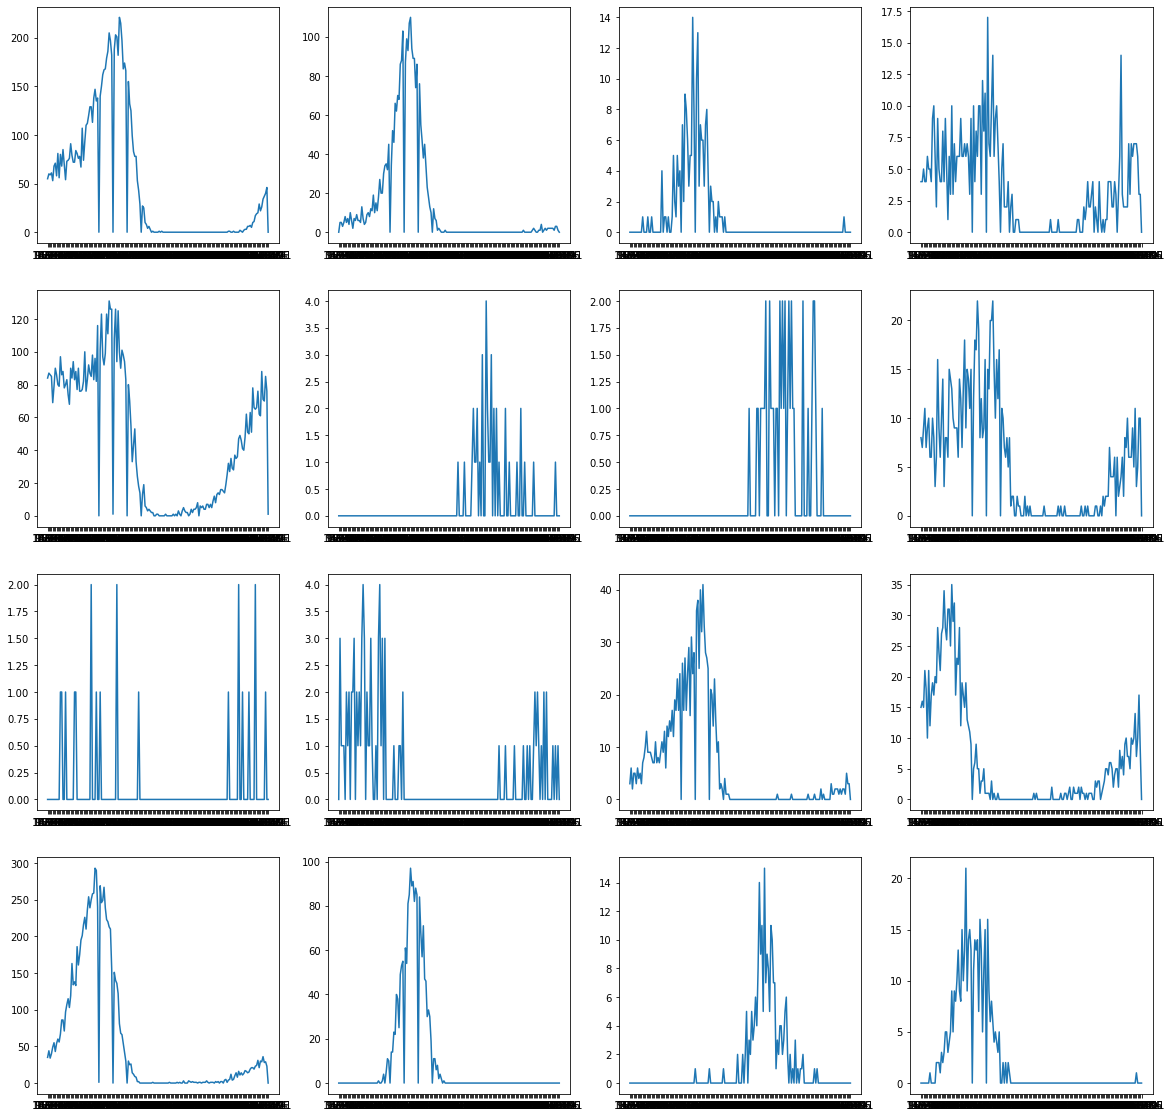

In [22]:
fig,ax=plt.subplots(4,4,figsize=(20,20))

for idx,col in enumerate(df.columns):
    
    ax[idx//4,idx%4].plot(df[col])

plt.show()
## 순서 
# ['1루타', '2루타', '3루타', '내야안타(1루타)', '땅볼아웃', '번트아웃', '번트안타', '병살타', '야수선택',
#        '인필드플라이', '직선타', '파울플라이', '플라이', '홈런', '희생번트', '희생플라이']

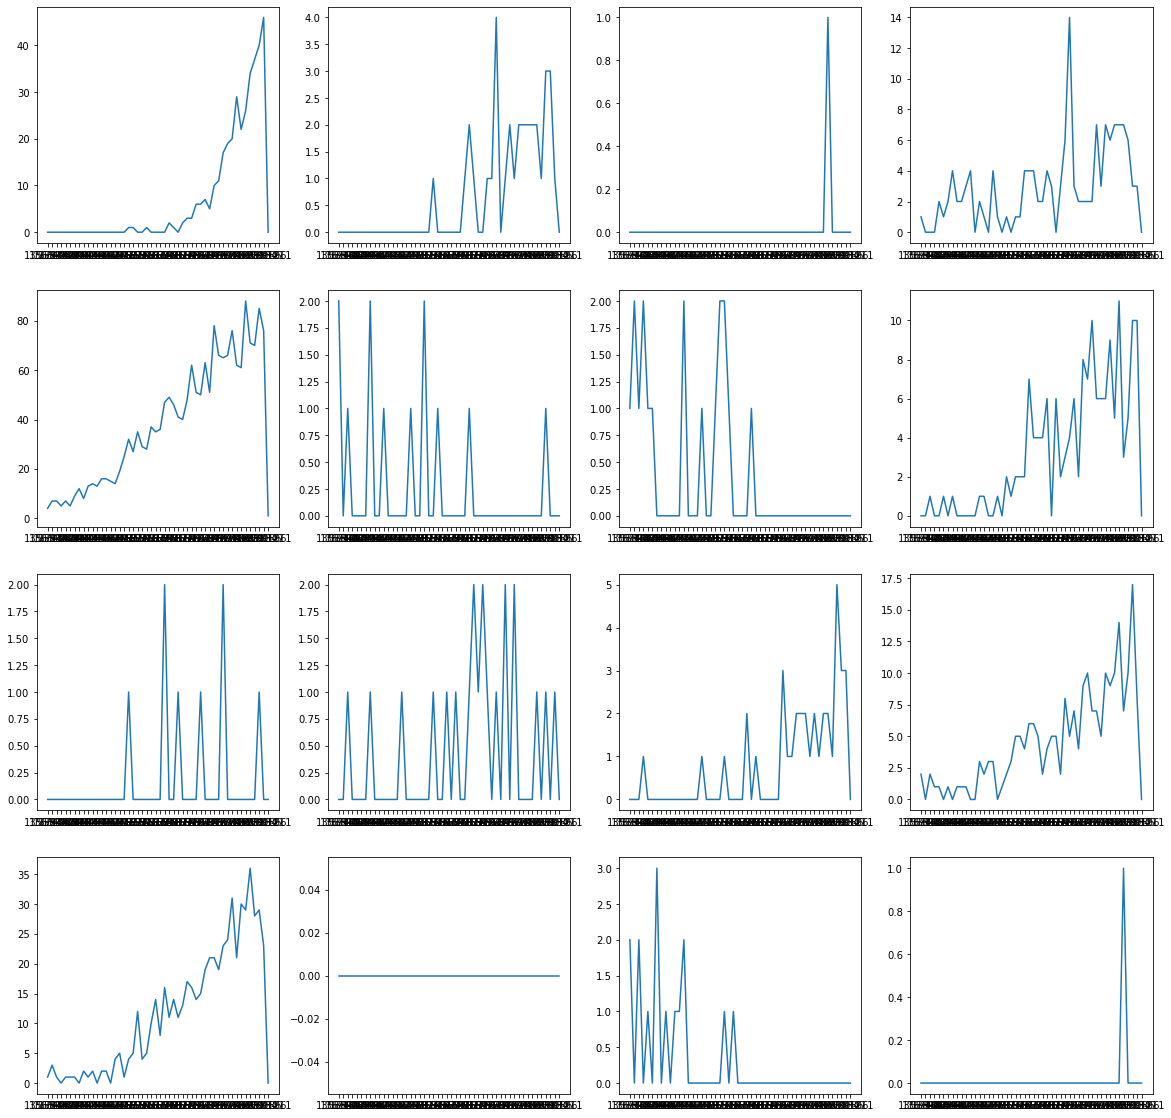

In [23]:
fig,ax=plt.subplots(4,4,figsize=(20,20))

for idx,col in enumerate(df.iloc[-50:,:].columns):
    
    ax[idx//4,idx%4].plot(df.iloc[-50:,:][col])

plt.show()

## 순서 
# ['1루타', '2루타', '3루타', '내야안타(1루타)', '땅볼아웃', '번트아웃', '번트안타', '병살타', '야수선택',
#        '인필드플라이', '직선타', '파울플라이', '플라이', '홈런', '희생번트', '희생플라이']


## 내야안타에서는 타구속도가 135 이상에서 높아질수록 내야안타의 확률이 높다.
## 1루타도 2루타도 3루타도 마찬가지다.

In [24]:
## 김하성,'아쉬운 직선타 아웃' [사진] | 다음스포츠 - Daum
## 직선타는 아웃이다. 

## 타구속도 평균이 눈에 띈다. 
## 
barrel2018[barrel2018['타격결과'].isin(['2루타','3루타','홈런'])].describe(include='all')

,연도,경기코드,타구코드,선수코드,팀코드,이닝,타구속도(km/h),발사각도,타격결과,상대투수 투구구속(km/h),해당구장,타구속도버림,타구속도올림,타구속도구간,#
count,4407.0,4407,4407,4407,4407,4407,4407.000000,4407.00000,4407,4407.000000,4407,4407,4407,4407,4407.0
unique,NaN,699,4401,210,10,12,NaN,NaN,3,NaN,9,97,97,97,NaN
top,NaN,20180504OBLG0,180531_192354,78224,OB,3,NaN,NaN,2루타,NaN,잠실,154,155,154~155,NaN
freq,NaN,16,2,79,500,546,NaN,NaN,2519,NaN,821,213,213,213,NaN
mean,2018.0,NaN,NaN,NaN,NaN,NaN,150.978434,21.26796,NaN,135.571888,NaN,NaN,NaN,NaN,1.0
std,0.0,NaN,NaN,NaN,NaN,NaN,12.791803,10.91192,NaN,9.478043,NaN,NaN,NaN,NaN,0.0
min,2018.0,NaN,NaN,NaN,NaN,NaN,72.301000,-50.20000,NaN,96.910000,NaN,NaN,NaN,NaN,1.0
25%,2018.0,NaN,NaN,NaN,NaN,NaN,145.971000,15.10000,NaN,129.260000,NaN,NaN,NaN,NaN,1.0
50%,2018.0,NaN,NaN,NaN,NaN,NaN,153.181000,22.00000,NaN,137.300000,NaN,NaN,NaN,NaN,1.0
75%,2018.0,NaN,NaN,NaN,NaN,NaN,159.051000,28.10000,NaN,143.105000,NaN,NaN,NaN,NaN,1.0


In [25]:
## 희생번트, 희생플라이로 희생지표 하나 만들어도 괜찮을 것 같은.
## 1루타로만 출루율을 볼수 있다.
## 1루타라도 barrel을 잘 반영할 수 있다면 타구속도가 